# Waste Sorting Using Computer Vision

Found 22564 images belonging to 2 classes.
Found 2513 images belonging to 2 classes.


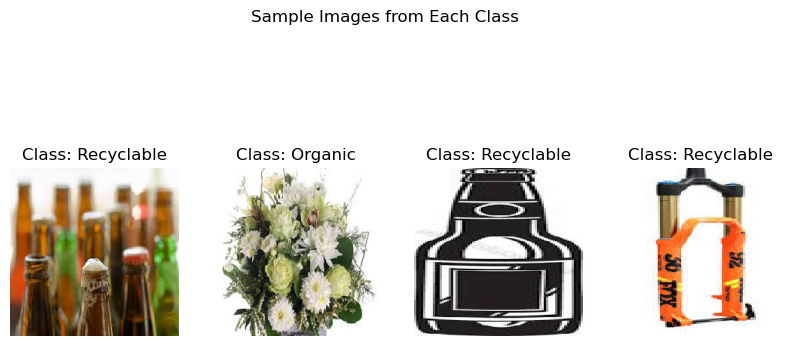

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up paths to the train and test directories
base_dir = r'C:\Users\hp\Downloads\archive (2)\DATASET\DATASET'
train_dir = base_dir + r'\TRAIN'  # Corrected path
test_dir = base_dir + r'\TEST'    # Corrected path

# Use ImageDataGenerator to prepare the data for training and testing
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load training and testing data
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224), 
    batch_size=32,
    class_mode='binary'
)

# Display sample images from the training data
plt.figure(figsize=(10, 5))
for i in range(4):  # Display 4 images (2 from each class if available)
    images, labels = next(train_data)  # Get a batch of images and labels
    plt.subplot(1, 4, i + 1)
    plt.imshow(images[i])  # Display the i-th image in the batch
    class_label = "Organic" if labels[i] == 0 else "Recyclable"
    plt.title(f"Class: {class_label}")
    plt.axis('off')

plt.suptitle("Sample Images from Each Class")
plt.show()


In [3]:
#include_top=False: Excludes the fully connected layers at the top of MobileNetV2
#weights='imagenet': Uses pre-trained weights from the ImageNet dataset
mobilenet_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freezes all the layers in the pre-trained MobileNetV2 to ensures that only the custom layers willlearn from new data
mobilenet_model.trainable = False  

# Add custom layers for classification
model = tf.keras.Sequential([
    mobilenet_model,
    tf.keras.layers.GlobalAveragePooling2D(), #reduces the spatial dimensions of single vector(summation of matrix)
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# We start with a pre-trained MobileNet model, adding layers to classify waste images into O or R.

### Train model

In [6]:
history = model.fit(
    train_data,
    validation_data = test_data,
    epochs=3
)

model.save('mobilenet_waste_classifier.h5')

loss,accuracy = model.evaluate(test_data)
print("Model accuracy:",accuracy)

C:\Users\hp\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3
706/706 ━━━━━━━━━━━━━━━━━━━━ 822s 1s/step - accuracy: 0.8639 - loss: 0.3098 - val_accuracy: 0.8663 - val_loss: 0.2968
Epoch 2/3
706/706 ━━━━━━━━━━━━━━━━━━━━ 828s 1s/step - accuracy: 0.9354 - loss: 0.1731 - val_accuracy: 0.8735 - val_loss: 0.2923
Epoch 3/3
706/706 ━━━━━━━━━━━━━━━━━━━━ 504s 714ms/step - accuracy: 0.9410 - loss: 0.1587 - val_accuracy: 0.8838 - val_loss: 0.2716


79/79 ━━━━━━━━━━━━━━━━━━━━ 24s 301ms/step - accuracy: 0.8972 - loss: 0.2494
Model accuracy: 0.883804202079773


79/79 ━━━━━━━━━━━━━━━━━━━━ 25s 303ms/step
Classification Report:
               precision    recall  f1-score   support

     Organic       0.56      0.65      0.60      1401
  Recyclable       0.45      0.36      0.40      1112

    accuracy                           0.52      2513
   macro avg       0.51      0.51      0.50      2513
weighted avg       0.51      0.52      0.51      2513

Confusion Matrix:
 [[910 491]
 [707 405]]


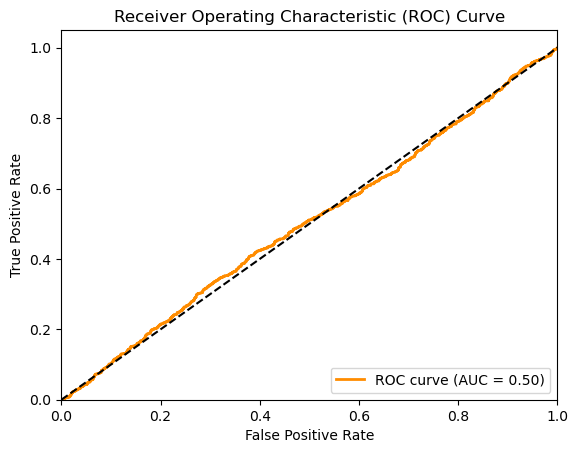

In [8]:
#Evaluation
#roc curve is graphical representation
#auc curve is scaler representationn...auc=1 classification
#auc=0.5 random classification
#auc<0.5 low

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Generate predictions
y_pred_prob = model.predict(test_data).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to binary predictions
y_true = test_data.classes  # True labels from test data

# Print classification report
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['Organic', 'Recyclable']))

# Print confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 853ms/step


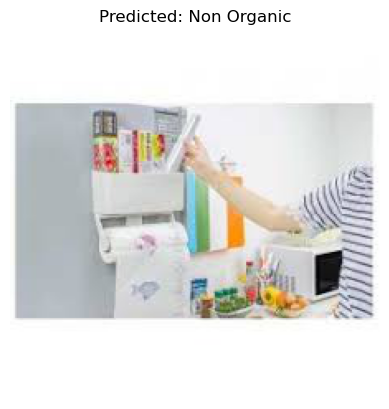

In [10]:
#Testing

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Path to the trained model and test image
model_path = 'mobilenet_waste_classifier.h5'
test_image_path = r"C:\Users\hp\Downloads\archive (2)\DATASET\TEST\R\R_11091.jpg"

# Load the trained model
model = tf.keras.models.load_model(model_path)

# Load and prepare the test image
test_img = load_img(test_image_path, target_size=(224, 224))  # Load image and resize
test_img_array = img_to_array(test_img) / 255.0  # Normalize pixel values
test_img_array = np.expand_dims(test_img_array, axis=0)  # Add batch dimension

# Predict the class of the test image
predicted_prob = model.predict(test_img_array)[0][0]
predicted_class = 'Organic' if predicted_prob < 0.5 else 'Non Organic'

# Display the test image and prediction
plt.imshow(test_img)
plt.title(f"Predicted: {predicted_class}")
plt.axis('off')
plt.show()